In [29]:
# estatísticas básicas
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



file_name = '../measurements.csv'
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".")
df.head()

,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,Ada,binary-trees,-1,103.249634,77.210144,0.0,9.470093,2783.0,28.8,202904.0
1,Ada,binary-trees,-1,102.630920,76.057190,0.0,9.618042,2844.0,28.2,202908.0
2,Ada,binary-trees,-1,102.921081,76.936951,0.0,9.476868,2782.0,29.8,202900.0
3,Ada,binary-trees,-1,103.698730,78.182007,0.0,9.302795,2738.0,29.8,202796.0
4,Ada,binary-trees,-1,104.284241,77.472168,0.0,9.556763,2865.0,30.8,202912.0


In [30]:
df = df[df['Time'] != 'error']

In [31]:
# List of variables to be cast to float
variables_to_cast = ['Package', 'Core', 'GPU', 'DRAM', 'Time', 'Temperature', 'Memory']

# Iterate through the specified variables and cast them to float
for variable in variables_to_cast:
    df[variable] = pd.to_numeric(df[variable], errors='coerce').astype(float)

df['Program'] = df['Program'].str.lstrip()
# Display the modified DataFrame
df.head()


,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,Ada,binary-trees,-1,103.249634,77.210144,0.0,9.470093,2783.0,28.8,202904.0
1,Ada,binary-trees,-1,102.630920,76.057190,0.0,9.618042,2844.0,28.2,202908.0
2,Ada,binary-trees,-1,102.921081,76.936951,0.0,9.476868,2782.0,29.8,202900.0
3,Ada,binary-trees,-1,103.698730,78.182007,0.0,9.302795,2738.0,29.8,202796.0
4,Ada,binary-trees,-1,104.284241,77.472168,0.0,9.556763,2865.0,30.8,202912.0


In [32]:
df.dtypes

Language        object
Program         object
PowerLimit       int64
Package        float64
Core           float64
GPU            float64
DRAM           float64
Time           float64
Temperature    float64
Memory         float64
dtype: object

# Analise dos dados

In [33]:
dfAnalise = df.drop(['GPU', 'Core','DRAM'], axis=1)

In [34]:
dfAnalise.shape[0]

20900

## Tratamento

### Remover extremos

In [35]:
group_columns = ['Language', 'Program','PowerLimit']
value_column = 'Package'
n_values_to_remove = 3

# Define a function to remove the lowest and highest values within each group
def remove_extremes(group):
    sorted_group = group.sort_values(value_column)
    return sorted_group.iloc[n_values_to_remove:-n_values_to_remove]

# Apply the function within each group using groupby with multiple columns
dfAnalise = dfAnalise.groupby(group_columns, group_keys=False, sort=False).apply(remove_extremes)

In [36]:
dfAnalise.shape[0]

14630

### Remoção de linguagens que não têm todas as execuções

In [37]:
#Remoção do pidits e do Lisp (tem uma execução inválida)
dfAnalise = dfAnalise[dfAnalise['Program'] != 'pidigits']
dfAnalise = dfAnalise[dfAnalise['Language'] != 'Lisp']

In [38]:
languagesProgramImplm = {}
for language, group in dfAnalise.groupby('Language'):
    programs = group['Program'].unique().tolist()
    languagesProgramImplm[language] = programs
for language in languagesProgramImplm:
    print(language, " -> " , languagesProgramImplm[language])

Ada  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C++  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
CSharp  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
Dart  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
Erlang  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
FSharp  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 's

In [39]:
for language in languagesProgramImplm:
    languagesProgramImplm[language] = len(languagesProgramImplm[language])
    print(language, " -> " , languagesProgramImplm[language])

Ada  ->  9
C  ->  9
C++  ->  9
CSharp  ->  9
Dart  ->  9
Erlang  ->  9
FSharp  ->  8
Go  ->  9
Haskell  ->  9
Java  ->  9
JavaScript  ->  9
Julia  ->  9
Lua  ->  9
OCaml  ->  9
PHP  ->  9
Pascal  ->  8
Perl  ->  9
Python  ->  9
Racket  ->  9
Ruby  ->  9
Rust  ->  9
Swift  ->  9


In [40]:
dfAnalise = dfAnalise[dfAnalise['Language'] != 'FSharp']
dfAnalise = dfAnalise[dfAnalise['Language'] != 'Pascal']

## Analise

### Verificar em média qual é o powerlimit em que obtivemos melhores resultados

#### Each Language-Program best PowerLimit value minimize Package

In [41]:
group_columns = ['Language', 'Program','PowerLimit']
#languages = dfAnalise.groupby('Language', group_keys=False, sort=False)

dfBestPower = dfAnalise.groupby(group_columns)['Package'].mean().reset_index(name='Package')

# Sort the DataFrame by 'Package' in ascending order
dfBestPower = dfBestPower.sort_values(by='Package')

# Keep only the first row for each combination of 'Language' and 'Program'
dfBestPower = dfBestPower.groupby(['Language', 'Program']).first().reset_index()

# Display the result
dfBestPower.head(10)

,Language,Program,PowerLimit,Package
0,Ada,binary-trees,15,88.593070
1,Ada,fannkuch-redux,25,243.025391
2,Ada,fasta,15,43.239110
3,Ada,k-nucleotide,15,124.988883
4,Ada,mandelbrot,15,110.830335
5,Ada,n-body,15,90.635302
6,Ada,regex-redux,15,112.315648
7,Ada,reverse-complement,15,6.710593
8,Ada,spectral-norm,15,26.433943
9,C,binary-trees,15,34.545585


#### PowerLimit mode for each Language

In [42]:
# Group by 'Language' and calculate the mode for 'PowerLimit'
dfBestPower = dfBestPower.groupby('Language')['PowerLimit'].apply(lambda x: x.mode().iloc[0]).reset_index()
print(dfBestPower)

#With this table we can see that PowerLimit at 15 is the value that saves the most energy

      Language  PowerLimit
0          Ada          15
1            C          15
2          C++          15
3       CSharp          15
4         Dart          15
5       Erlang          15
6           Go          15
7      Haskell          15
8         Java          15
9   JavaScript          15
10       Julia          15
11         Lua          15
12       OCaml          15
13         PHP          15
14        Perl          15
15      Python          15
16      Racket          15
17        Ruby          15
18        Rust          15
19       Swift          15


### Ranking de Linguagens

#### Default Ranking Calculation

In [43]:
dfRanking = dfAnalise[['Language','Program','PowerLimit','Package','Time']]
dfRanking = dfRanking[dfRanking['PowerLimit'].isin([-1,15])]
dfRanking.rename(columns={'Package': 'Energy (J)'}, inplace=True)
dfRanking.rename(columns={'Time': 'Time (ms)'}, inplace=True)
dfRanking.head(5)

,Language,Program,PowerLimit,Energy (J),Time (ms)
12,Ada,binary-trees,-1,103.249390,2804.0
0,Ada,binary-trees,-1,103.249634,2783.0
19,Ada,binary-trees,-1,103.401611,2777.0
3,Ada,binary-trees,-1,103.698730,2738.0
15,Ada,binary-trees,-1,103.806030,2770.0


#### Calcular Médias

In [44]:
dfRanking = dfRanking.groupby(['Language', 'Program', 'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()
dfRanking.head(10)

,Language,Program,PowerLimit,Energy (J),Time (ms)
0,Ada,binary-trees,-1,104.080684,2771.285714
1,Ada,binary-trees,15,88.593070,5930.571429
2,Ada,fannkuch-redux,-1,282.892325,6785.500000
3,Ada,fannkuch-redux,15,245.107631,16399.142857
4,Ada,fasta,-1,44.873688,2489.571429
5,Ada,fasta,15,43.239110,2890.428571
6,Ada,k-nucleotide,-1,146.951468,5500.785714
7,Ada,k-nucleotide,15,124.988883,8363.642857
8,Ada,mandelbrot,-1,124.386819,3616.000000
9,Ada,mandelbrot,15,110.830335,7413.857143


In [45]:
dataset_power_no_limit = dfRanking[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dataset_power_limit_15 = dfRanking[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])

#### Ranking with not limitations

In [46]:
# Create a dictionary to store the sorted DataFrames for each program
dict_no_limit = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_no_limit.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_no_limit[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in dict_no_limit.items():
    print(f"Program: {program}")
    print(sorted_df[['Language', 'Energy (J)', 'Time (ms)']])  # Exclude 'Program' and 'PowerLimit' columns
    print("\n")


Program: binary-trees
      Language   Energy (J)     Time (ms)
0          C++    35.893250    889.500000
1            C    41.419778   1030.000000
2         Rust    41.709355    976.142857
3      Haskell    48.777679   2238.928571
4         Java    86.143917   2215.928571
5          Ada   104.080684   2771.285714
6       Racket   111.901746   4079.642857
7        OCaml   129.308877   3715.642857
8       Erlang   138.257525   3826.785714
9   JavaScript   220.178271   5738.142857
10        Dart   327.175585  10538.500000
11       Julia   376.561288  14328.928571
12      CSharp   414.455396  24575.285714
13       Swift   453.466426  12383.071429
14          Go   538.418566  11831.142857
15         PHP   824.551518  20531.071429
16        Ruby  1097.580318  29156.857143
17        Perl  1475.272879  33724.285714
18      Python  1522.273067  36251.857143
19         Lua  1736.913775  43028.214286


Program: fannkuch-redux
      Language    Energy (J)      Time (ms)
0            C     79.6052

#### Ranking with PowerLimit 15

In [47]:
#Fazer o dicionário
# Create a dictionary to store the sorted DataFrames for each program
dict_limit_15 = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_limit_15.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_limit_15[program] = sorted_df

In [48]:
# Initialize an empty list to store the comparison results
comparison_results = []

# Iterate over programs in the first dictionary
for program, df1 in dict_limit_15.items():
    # Check if the program exists in the second dictionary
    if program in dict_no_limit:
        df2 = dict_no_limit[program]

        # Iterate over languages in the program
        for language in df1['Language']:
            # Extract data for the specific language in both dictionaries
            lang_df1 = df1[df1['Language'] == language]
            lang_df2 = df2[df2['Language'] == language]

            # Calculate the differences
            position_changes = lang_df1.index[0] - lang_df2.index[0]
            energy_difference = lang_df1['Energy (J)'].iloc[0] - lang_df2['Energy (J)'].iloc[0]
            time_difference = lang_df1['Time (ms)'].iloc[0] - lang_df2['Time (ms)'].iloc[0]

            # Append the results to the comparison list
            comparison_results.append({
                'Program': program,
                'Language': language,
                'Energy (J)': lang_df1['Energy (J)'].iloc[0],
                'Time (ms)': lang_df1['Time (ms)'].iloc[0],
                'Position Changes': position_changes,
                'Energy Difference': energy_difference,
                'Energy Difference %': energy_difference/lang_df2['Energy (J)'].iloc[0]*100,
                'Time Difference': time_difference,
                'Time Difference %': time_difference/lang_df2['Time (ms)'].iloc[0]*100
            })

# Convert the list of dictionaries into a DataFrame
dataset_power_limit_15 = pd.DataFrame(comparison_results)

# Display the comparison results
dataset_power_limit_15.head(10)

,Program,Language,Energy (J),Time (ms),Position Changes,Energy Difference,Energy Difference %,Time Difference,Time Difference %
0,binary-trees,C++,30.002563,2007.357143,0,-5.890686,-16.411682,1117.857143,125.672529
1,binary-trees,Rust,33.501059,2241.285714,-1,-8.208296,-19.679747,1265.142857,129.606322
2,binary-trees,C,34.545585,2310.571429,1,-6.874193,-16.596403,1280.571429,124.327323
3,binary-trees,Haskell,47.270813,3294.071429,0,-1.506866,-3.089254,1055.142857,47.127134
4,binary-trees,Java,62.719583,4199.714286,0,-23.424334,-27.192093,1983.785714,89.523902
5,binary-trees,Ada,88.593070,5930.571429,0,-15.487614,-14.880392,3159.285714,114.000722
6,binary-trees,Racket,91.678606,6186.785714,0,-20.223140,-18.072229,2107.142857,51.650179
7,binary-trees,OCaml,108.893106,7284.357143,0,-20.415771,-15.788376,3568.714286,96.045676
8,binary-trees,Erlang,115.088261,7811.714286,0,-23.169264,-16.758049,3984.928571,104.132524
9,binary-trees,JavaScript,182.375854,12206.357143,0,-37.802416,-17.169004,6468.214286,112.723131


In [49]:
#Fazer o dicionário
# Create a dictionary to store the sorted DataFrames for each program
dict_limit_15 = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_limit_15.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_limit_15[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in dict_limit_15.items():
    print(f"Program: {program}")
    print(sorted_df.drop(columns=['Program']))
    print("\n")

Program: binary-trees
      Language   Energy (J)     Time (ms)  Position Changes  \
0          C++    30.002563   2007.357143                 0   
1         Rust    33.501059   2241.285714                -1   
2            C    34.545585   2310.571429                 1   
3      Haskell    47.270813   3294.071429                 0   
4         Java    62.719583   4199.714286                 0   
5          Ada    88.593070   5930.571429                 0   
6       Racket    91.678606   6186.785714                 0   
7        OCaml   108.893106   7284.357143                 0   
8       Erlang   115.088261   7811.714286                 0   
9   JavaScript   182.375854  12206.357143                 0   
10        Dart   267.052364  17906.500000                 0   
11       Julia   335.743910  22519.285714                 0   
12       Swift   381.903469  25544.714286                -1   
13      CSharp   393.662898  30201.714286                 1   
14          Go   449.794721  3008

In [50]:
dfRanking_dict = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dfRanking.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dfRanking_dict[program] = sorted_df

binaryTrees = dfRanking_dict["binary-trees"]
binaryTrees['Type'] = "undefined"

In [51]:
binaryTrees.loc[binaryTrees['Language'] == 'Ada', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'C', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'C++', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'Go', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'Haskell', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'OCaml', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'Rust', 'Type'] = "Compiled"
binaryTrees.loc[binaryTrees['Language'] == 'Swift', 'Type'] = "Compiled"

In [52]:
binaryTrees.loc[binaryTrees['Language'] == 'Dart', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'JavaScript', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Lua', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Perl', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'PHP', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Python', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Ruby', 'Type'] = "Interpreted"
binaryTrees.loc[binaryTrees['Language'] == 'Julia', 'Type'] = "Interpreted"

In [53]:
binaryTrees.loc[binaryTrees['Language'] == 'CSharp', 'Type'] = "Virtual Machine"
binaryTrees.loc[binaryTrees['Language'] == 'Erlang', 'Type'] = "Virtual Machine"
binaryTrees.loc[binaryTrees['Language'] == 'Java', 'Type'] = "Virtual Machine"
binaryTrees.loc[binaryTrees['Language'] == 'Racket', 'Type'] = "Virtual Machine"

In [57]:
binaryTrees.head(40)

,Language,Program,PowerLimit,Energy (J),Time (ms),Type
0,C++,binary-trees,15,30.002563,2007.357143,Compiled
1,Rust,binary-trees,15,33.501059,2241.285714,Compiled
2,C,binary-trees,15,34.545585,2310.571429,Compiled
3,C++,binary-trees,-1,35.893250,889.500000,Compiled
4,C,binary-trees,-1,41.419778,1030.000000,Compiled
5,Rust,binary-trees,-1,41.709355,976.142857,Compiled
6,Haskell,binary-trees,15,47.270813,3294.071429,Compiled
7,Haskell,binary-trees,-1,48.777679,2238.928571,Compiled
8,Java,binary-trees,15,62.719583,4199.714286,Virtual Machine
9,Java,binary-trees,-1,86.143917,2215.928571,Virtual Machine


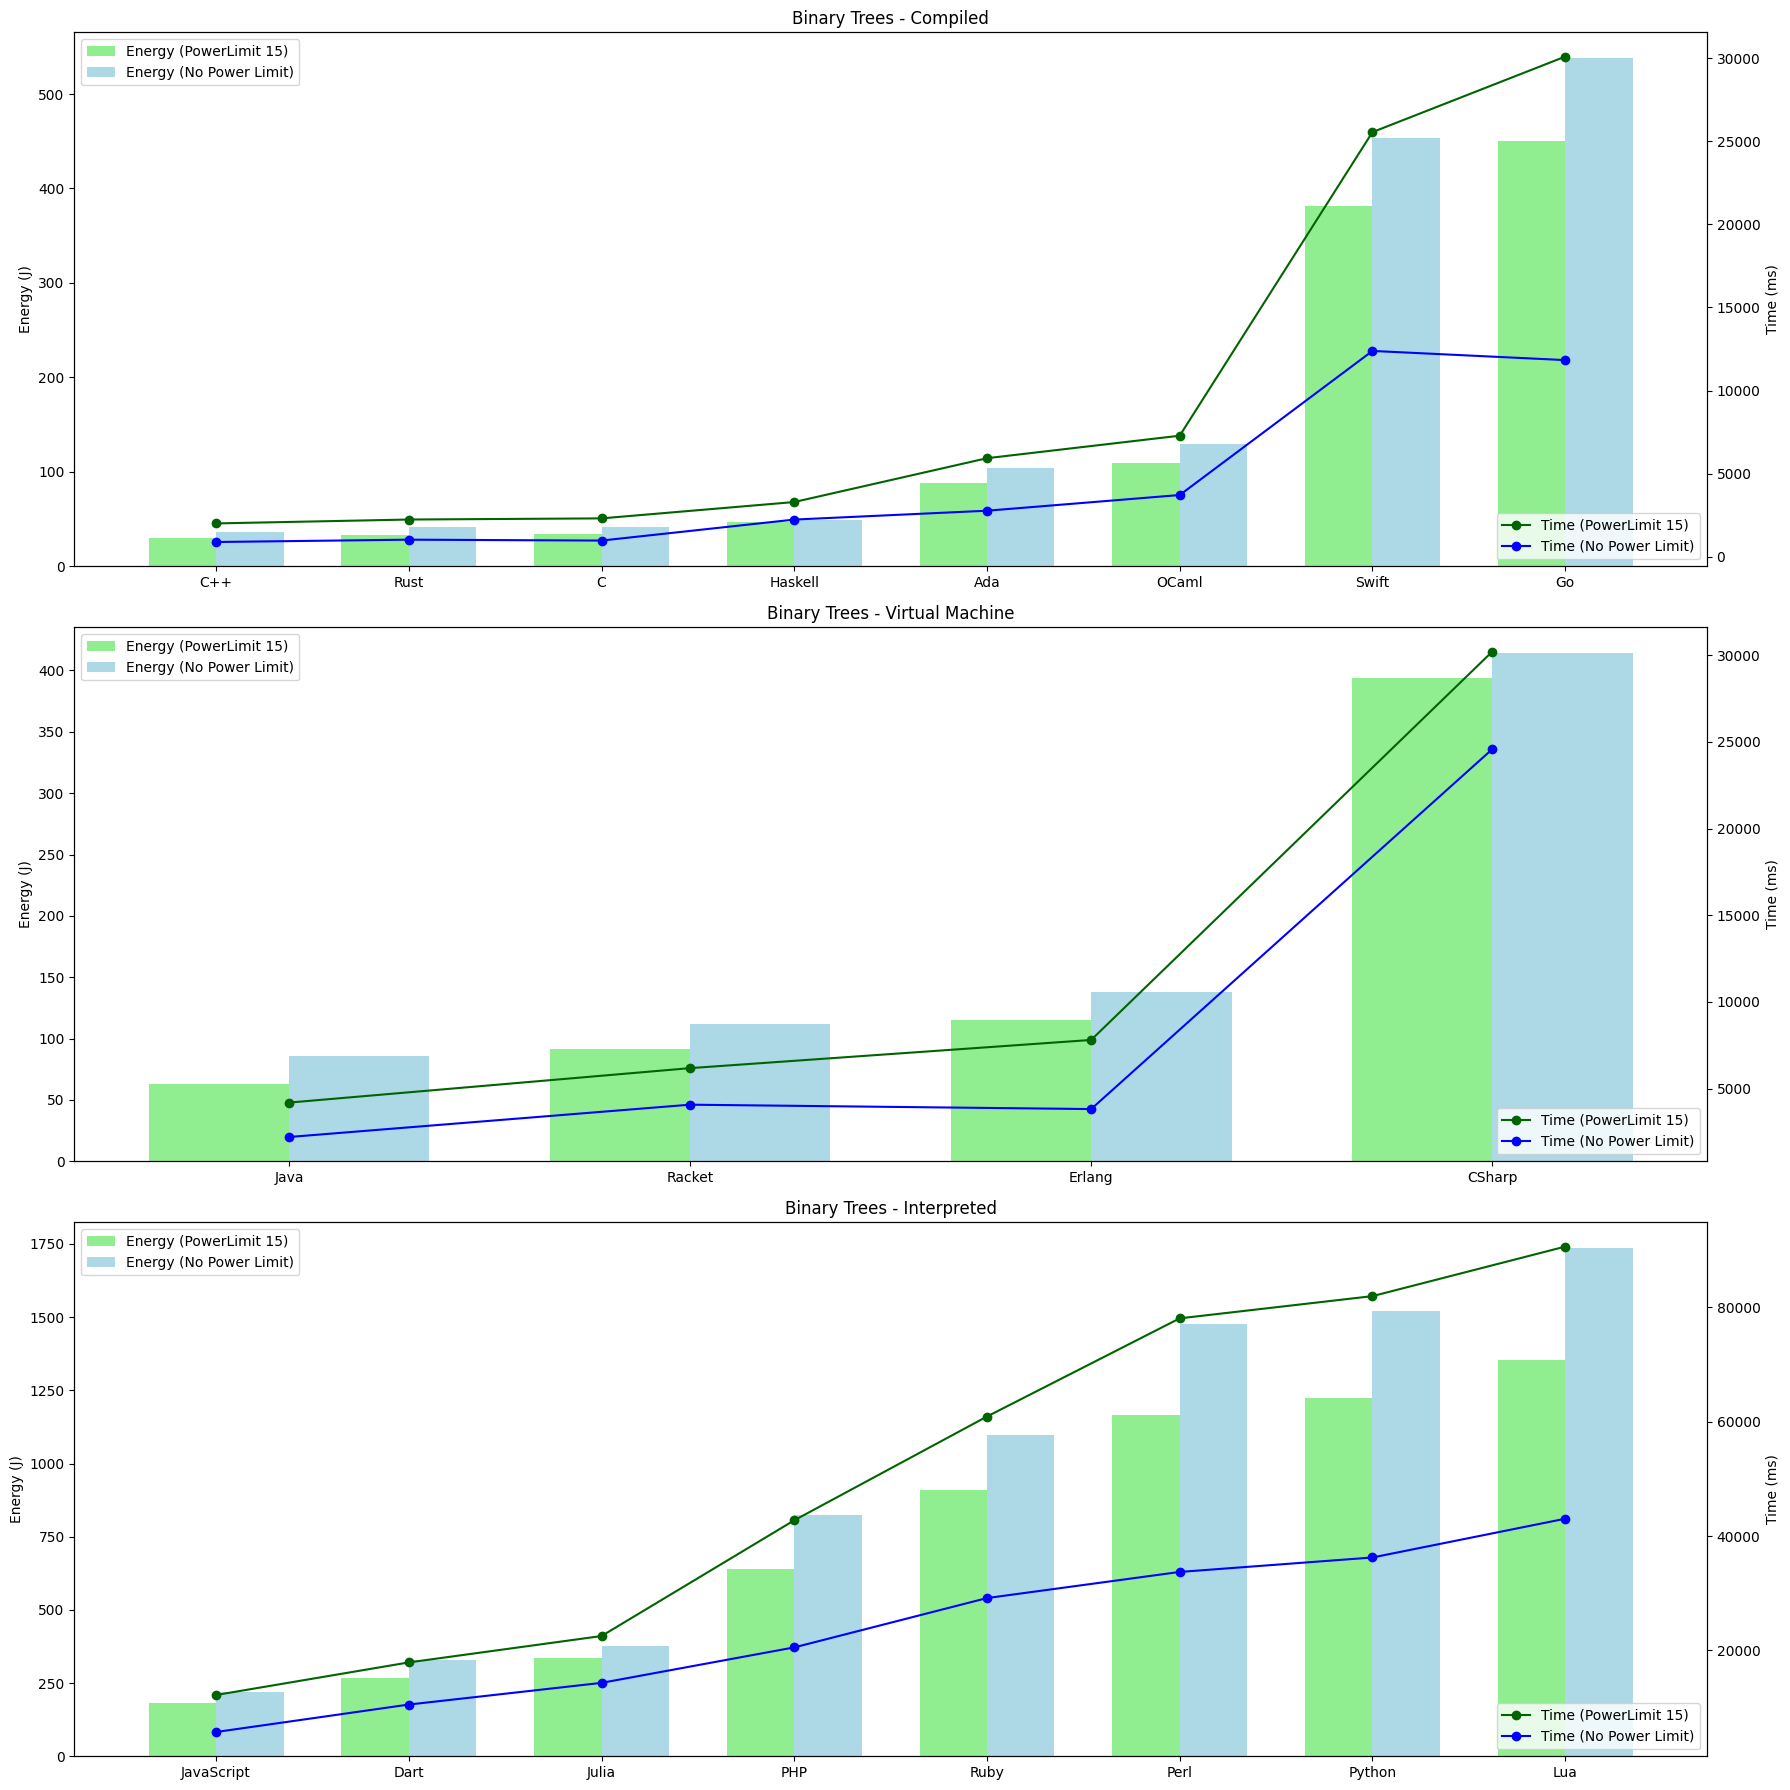

In [82]:
# Separate data by Type and PowerLimit
compiled_15_data = binaryTrees[(binaryTrees['Type'] == 'Compiled') & (binaryTrees['PowerLimit'] == 15)]
compiled_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Compiled') & (binaryTrees['PowerLimit'] == -1)]

vm_15_data = binaryTrees[(binaryTrees['Type'] == 'Virtual Machine') & (binaryTrees['PowerLimit'] == 15)]
vm_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Virtual Machine') & (binaryTrees['PowerLimit'] == -1)]

interpreted_15_data = binaryTrees[(binaryTrees['Type'] == 'Interpreted') & (binaryTrees['PowerLimit'] == 15)]
interpreted_minus_1_data = binaryTrees[(binaryTrees['Type'] == 'Interpreted') & (binaryTrees['PowerLimit'] == -1)]

# Function to plot data
def plot_data(ax, energy_15, time_15, energy_minus_1, time_minus_1, label):
    x = np.arange(len(energy_15))
    width = 0.35

    ax.bar(x - width/2, energy_15['Energy (J)'], width, color='lightgreen', label='Energy (PowerLimit 15)')
    ax.bar(x + width/2, energy_minus_1['Energy (J)'], width, color='lightblue', label='Energy (No Power Limit)')
    
    ax2 = ax.twinx()
    ax2.plot(x, energy_15['Time (ms)'], color='darkgreen', marker='o', label='Time (PowerLimit 15)')
    ax2.plot(x, time_minus_1['Time (ms)'], color='blue', marker='o', label='Time (No Power Limit)')
    
    ax.set_xticks(x)
    ax.set_xticklabels(energy_15['Language'])
    ax.set_ylabel('Energy (J)')
    ax2.set_ylabel('Time (ms)')
    ax.set_title(label)
    ax.legend(loc='upper left')
    ax2.legend(loc='lower right')  # Adjusting legend position


# Plotting
fig, axs = plt.subplots(3, 1, figsize=(18, 18))

plot_data(axs[0], compiled_15_data, compiled_15_data, compiled_minus_1_data, compiled_minus_1_data, 'Binary Trees - Compiled')
plot_data(axs[1], vm_15_data, vm_15_data, vm_minus_1_data, vm_minus_1_data, 'Binary Trees - Virtual Machine')
plot_data(axs[2], interpreted_15_data, interpreted_15_data, interpreted_minus_1_data, interpreted_minus_1_data, 'Binary Trees - Interpreted')

plt.tight_layout()
plt.show()

In [ ]:
# Filtering data for PowerLimit 15
df_15 = df[df['PowerLimit'] == 15].sort_values(by='Energy (J)')

# Plotting
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(df_15['Language'], df_15['Energy (J)'], color='b', label='Energy (J)')
ax2.plot(df_15['Language'], df_15['Time (ms)'], color='r', marker='o', label='Time (ms)')

ax1.set_xlabel('Language')
ax1.set_ylabel('Energy (J)', color='b')
ax2.set_ylabel('Time (ms)', color='r')

plt.title('Energy and Time Consumption for Power Limit 15')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [55]:
binaryTrees_dict = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in binaryTrees.groupby('Type'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    binaryTrees_dict[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in binaryTrees_dict.items():
    print(f"Program: {program}")
    print(sorted_df.drop(columns=['Program']))
    print("\n")

Program: Compiled
   Language  PowerLimit  Energy (J)     Time (ms)      Type
0       C++          15   30.002563   2007.357143  Compiled
1      Rust          15   33.501059   2241.285714  Compiled
2         C          15   34.545585   2310.571429  Compiled
3       C++          -1   35.893250    889.500000  Compiled
4         C          -1   41.419778   1030.000000  Compiled
5      Rust          -1   41.709355    976.142857  Compiled
6   Haskell          15   47.270813   3294.071429  Compiled
7   Haskell          -1   48.777679   2238.928571  Compiled
8       Ada          15   88.593070   5930.571429  Compiled
9       Ada          -1  104.080684   2771.285714  Compiled
10    OCaml          15  108.893106   7284.357143  Compiled
11    OCaml          -1  129.308877   3715.642857  Compiled
12    Swift          15  381.903469  25544.714286  Compiled
13       Go          15  449.794721  30086.928571  Compiled
14    Swift          -1  453.466426  12383.071429  Compiled
15       Go          -

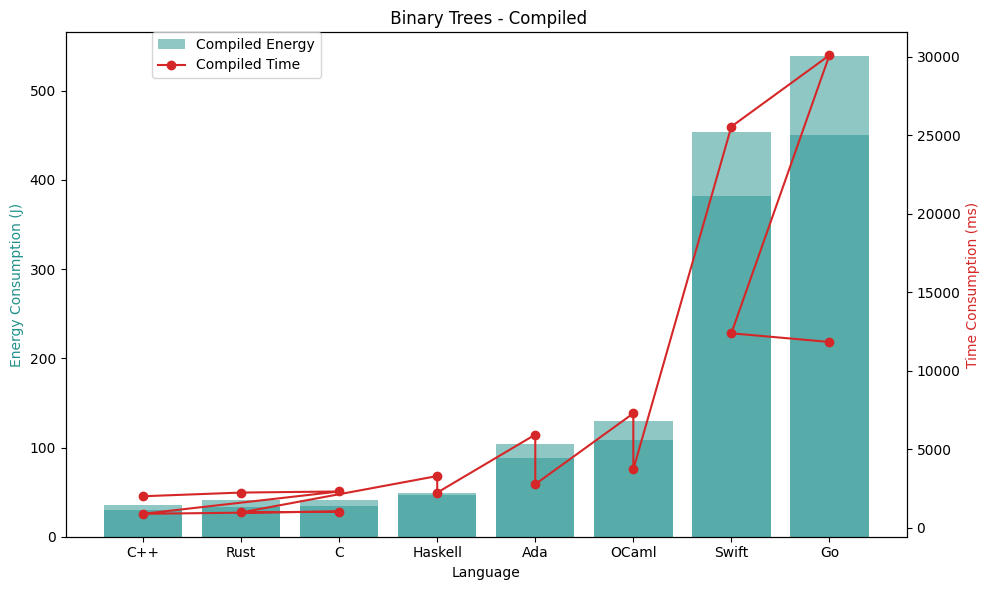

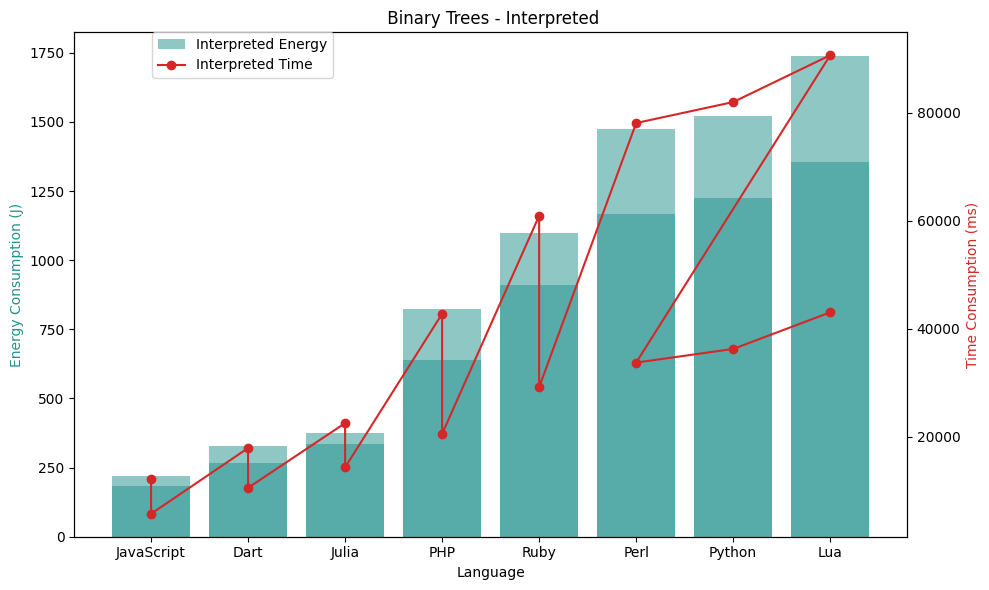

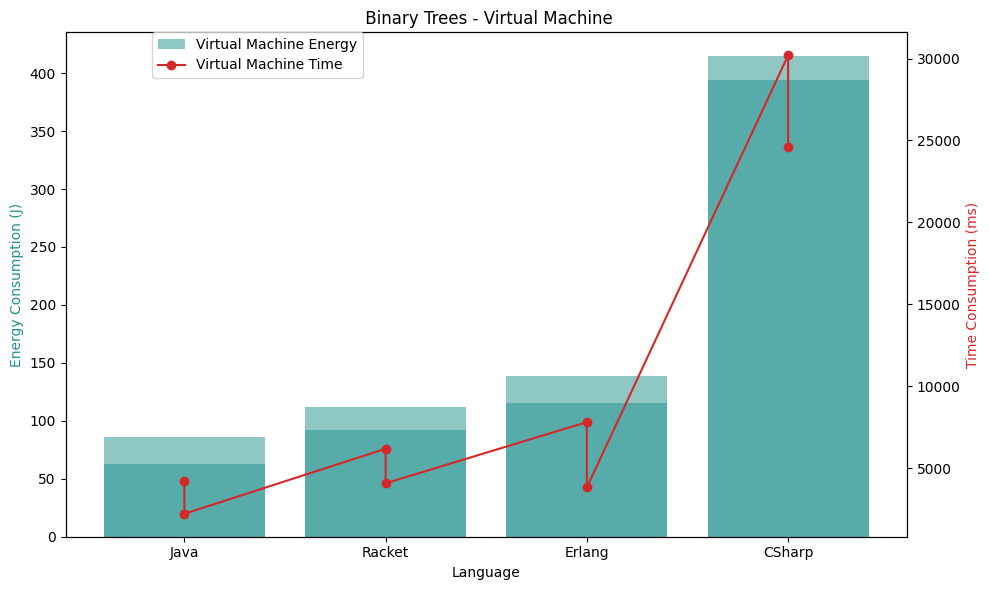

In [59]:
import matplotlib.pyplot as plt
# Function to plot
def plot_graph(data, title):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Language')
    ax1.set_ylabel('Energy Consumption (J)', color=plt.cm.viridis(0.5))
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time Consumption (ms)', color='tab:red')

    for program, values in data.items():
        ax1.bar([lang for lang in values['Language']], values['Energy (J)'], label=f'{program} Energy', color=plt.cm.viridis(0.5), alpha=0.5)
        ax2.plot([lang for lang in values['Language']], values['Time (ms)'], marker='o', linestyle='-', label=f'{program} Time', color='tab:red')

    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.95))
    plt.show()

# Plotting each type separately
for program_type, program_data in binaryTrees_dict.items():
    plot_graph({program_type: program_data}, f' Binary Trees - {program_type}')

### Gráficos finais com somas

In [22]:
#dfSomasPrograms = dfRanking.groupby(['Language' , 'Program' ,'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()
dfSomasPrograms = dfRanking.groupby(['Language' ,'PowerLimit']).agg({'Energy (J)': 'sum', 'Time (ms)': 'sum'}).reset_index()
dfSomasPrograms.head(5)

,Language,PowerLimit,Energy (J),Time (ms)
0,Ada,-1,965.524166,31068.285714
1,Ada,15,848.854514,56797.500000
2,C,-1,367.654096,11430.428571
3,C,15,316.371634,21146.071429
4,C++,-1,363.094875,11687.000000


In [23]:
dataset_power_no_limit = dfSomasPrograms[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dataset_power_limit_15 = dfSomasPrograms[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])

/tmp/ipykernel_6174/2430238798.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_power_no_limit = dfSomasPrograms[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
/tmp/ipykernel_6174/2430238798.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_power_limit_15 = dfSomasPrograms[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])


#### Gráficos finais com somas (no limit)

In [24]:
dataset_power_no_limit = dataset_power_no_limit.sort_values(by='Energy (J)').reset_index(drop=True)
dataset_power_no_limit.head(20)
#TODO

,Language,Energy (J),Time (ms)
0,C++,363.094875,1.168700e+04
1,C,367.654096,1.143043e+04
2,Rust,583.401062,1.677200e+04
3,CSharp,946.813529,4.256171e+04
4,Ada,965.524166,3.106829e+04
5,Java,1144.926470,3.275579e+04
6,Julia,1272.131326,6.048914e+04
7,OCaml,1471.454647,4.877514e+04
8,Go,1524.454882,4.108843e+04
9,JavaScript,1598.456948,5.035793e+04


In [25]:
# Define the reference values for Energy and Time
reference_energy = dataset_power_no_limit.loc[0, 'Energy (J)']
reference_time = dataset_power_no_limit.loc[0, 'Time (ms)']

# Normalize Energy and Time columns
dataset_power_no_limit_normalized = dataset_power_no_limit.copy()
dataset_power_no_limit_normalized['Energy Normalized'] = dataset_power_no_limit_normalized['Energy (J)'] / reference_energy
dataset_power_no_limit_normalized['Time Normalized'] = dataset_power_no_limit_normalized['Time (ms)'] / reference_time
dataset_power_no_limit_normalized = dataset_power_no_limit_normalized.drop(columns=['Energy (J)','Time (ms)'])
dataset_power_no_limit_normalized.head(20)
#TODO

,Language,Energy Normalized,Time Normalized
0,C++,1.000000,1.000000
1,C,1.012557,0.978046
2,Rust,1.606746,1.435099
3,CSharp,2.607620,3.641800
4,Ada,2.659151,2.658363
5,Java,3.153243,2.802754
6,Julia,3.503578,5.175763
7,OCaml,4.052535,4.173453
8,Go,4.198503,3.515738
9,JavaScript,4.402312,4.308884


#### Gráficos finais com somas (limit = 15)

In [26]:
dataset_power_limit_15 = dataset_power_limit_15.sort_values(by='Energy (J)').reset_index(drop=True)
dataset_power_limit_15.head(20)

,Language,Energy (J),Time (ms)
0,C,316.371634,2.114607e+04
1,C++,320.768877,2.144114e+04
2,Rust,510.964927,3.416450e+04
3,Ada,848.854514,5.679750e+04
4,CSharp,865.582267,6.189143e+04
5,Java,991.363586,6.631436e+04
6,Julia,1192.361145,7.981214e+04
7,OCaml,1268.793784,8.486129e+04
8,Go,1319.209922,8.822679e+04
9,JavaScript,1388.458078,9.292921e+04


In [27]:
result_df = []
#  Iterate over languages in the program
for language in dataset_power_limit_15['Language']:
    # Extract data for the specific language in both dictionaries
    row_df1 = dataset_power_limit_15[dataset_power_limit_15['Language'] == language]
    row_df2 = dataset_power_no_limit[dataset_power_no_limit['Language'] == language]

    # Calculate the differences
    position_changes = row_df1.index[0] - row_df2.index[0]
    energy_difference = row_df1['Energy (J)'].iloc[0] - row_df2['Energy (J)'].iloc[0]
    time_difference = row_df1['Time (ms)'].iloc[0] - row_df2['Time (ms)'].iloc[0]
    # Append the results to the comparison list
    result_df.append({
        'Language': language,
        'Energy (J)': row_df1['Energy (J)'].iloc[0],
        'Time (ms)': row_df1['Time (ms)'].iloc[0],
        'Position Changes': position_changes,
        'Energy Difference (J)': energy_difference,
        'Energy Difference %': energy_difference/row_df2['Energy (J)'].iloc[0]*100,
        'Time Difference (ms)': time_difference,
        'Time Difference %': time_difference/row_df2['Time (ms)'].iloc[0]*100
    })

# Convert the list of dictionaries into a DataFrame
result_df = pd.DataFrame(result_df)

# Display the comparison results
result_df.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,316.371634,2.114607e+04,-1,-51.282462,-13.948563,9.715643e+03,84.998063
1,C++,320.768877,2.144114e+04,1,-42.325997,-11.657008,9.754143e+03,83.461477
2,Rust,510.964927,3.416450e+04,0,-72.436135,-12.416182,1.739250e+04,103.699618
3,Ada,848.854514,5.679750e+04,-1,-116.669652,-12.083556,2.572921e+04,82.815043
4,CSharp,865.582267,6.189143e+04,1,-81.231262,-8.579436,1.932971e+04,45.415732
5,Java,991.363586,6.631436e+04,0,-153.562884,-13.412467,3.355857e+04,102.450821
6,Julia,1192.361145,7.981214e+04,0,-79.770181,-6.270593,1.932300e+04,31.944576
7,OCaml,1268.793784,8.486129e+04,0,-202.660863,-13.772824,3.608614e+04,73.984699
8,Go,1319.209922,8.822679e+04,0,-205.244960,-13.463499,4.713836e+04,114.724166
9,JavaScript,1388.458078,9.292921e+04,0,-209.998871,-13.137599,4.257129e+04,84.537404


In [28]:
result_df = []
#  Iterate over languages in the program
for language in dataset_power_limit_15['Language']:
    # Extract data for the specific language in both dictionaries
    row_df1 = dataset_power_limit_15[dataset_power_limit_15['Language'] == language]
    row_df2 = dataset_power_no_limit[dataset_power_no_limit['Language'] == language]

    # Calculate the differences
    position_changes = row_df1.index[0] - row_df2.index[0]
    energy_difference = row_df1['Energy (J)'].iloc[0] - row_df2['Energy (J)'].iloc[0]
    time_difference = row_df1['Time (ms)'].iloc[0] - row_df2['Time (ms)'].iloc[0]
    # Append the results to the comparison list
    result_df.append({
        'Language': language,
        'Energy (J)': row_df1['Energy (J)'].iloc[0],
        'Time (ms)': row_df1['Time (ms)'].iloc[0],
        'Position Changes': position_changes,
        'Energy Difference (J)': energy_difference,
        'Energy Difference %': energy_difference/row_df2['Energy (J)'].iloc[0]*100,
        'Time Difference (ms)': time_difference,
        'Time Difference %': time_difference/row_df2['Time (ms)'].iloc[0]*100
    })

# Convert the list of dictionaries into a DataFrame
result_df = pd.DataFrame(result_df)

# Display the comparison results
result_df.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,316.371634,2.114607e+04,-1,-51.282462,-13.948563,9.715643e+03,84.998063
1,C++,320.768877,2.144114e+04,1,-42.325997,-11.657008,9.754143e+03,83.461477
2,Rust,510.964927,3.416450e+04,0,-72.436135,-12.416182,1.739250e+04,103.699618
3,Ada,848.854514,5.679750e+04,-1,-116.669652,-12.083556,2.572921e+04,82.815043
4,CSharp,865.582267,6.189143e+04,1,-81.231262,-8.579436,1.932971e+04,45.415732
5,Java,991.363586,6.631436e+04,0,-153.562884,-13.412467,3.355857e+04,102.450821
6,Julia,1192.361145,7.981214e+04,0,-79.770181,-6.270593,1.932300e+04,31.944576
7,OCaml,1268.793784,8.486129e+04,0,-202.660863,-13.772824,3.608614e+04,73.984699
8,Go,1319.209922,8.822679e+04,0,-205.244960,-13.463499,4.713836e+04,114.724166
9,JavaScript,1388.458078,9.292921e+04,0,-209.998871,-13.137599,4.257129e+04,84.537404


In [29]:
# Define the reference values for Energy and Time
reference_energy = result_df.loc[0, 'Energy (J)']
reference_time = result_df.loc[0, 'Time (ms)']

# Normalize Energy and Time columns
result_df_normalized = result_df.copy()
result_df_normalized['Energy (J)'] = result_df_normalized['Energy (J)'] / reference_energy
result_df_normalized['Time (ms)'] = result_df_normalized['Time (ms)'] / reference_time
result_df_normalized.head(20)
#TODO

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,1.000000,1.000000,-1,-51.282462,-13.948563,9.715643e+03,84.998063
1,C++,1.013899,1.013954,1,-42.325997,-11.657008,9.754143e+03,83.461477
2,Rust,1.615078,1.615643,0,-72.436135,-12.416182,1.739250e+04,103.699618
3,Ada,2.683093,2.685960,-1,-116.669652,-12.083556,2.572921e+04,82.815043
4,CSharp,2.735967,2.926852,1,-81.231262,-8.579436,1.932971e+04,45.415732
5,Java,3.133541,3.136013,0,-153.562884,-13.412467,3.355857e+04,102.450821
6,Julia,3.768862,3.774325,0,-79.770181,-6.270593,1.932300e+04,31.944576
7,OCaml,4.010454,4.013099,0,-202.660863,-13.772824,3.608614e+04,73.984699
8,Go,4.169811,4.172254,0,-205.244960,-13.463499,4.713836e+04,114.724166
9,JavaScript,4.388693,4.394633,0,-209.998871,-13.137599,4.257129e+04,84.537404


In [30]:
result_df = result_df.sort_values(by='Energy Difference %')
result_df.head(20)

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
17,Python,28173.105609,1.884515e+06,0,-6955.773904,-19.800728,9.869861e+05,109.967083
19,Ruby,34053.900064,2.277910e+06,0,-8245.872197,-19.493893,1.211671e+06,113.639724
18,Perl,33100.910880,2.214195e+06,0,-7706.976214,-18.885997,1.197328e+06,117.746764
15,PHP,11854.182338,7.929690e+05,0,-2321.110325,-16.374338,3.943803e+05,98.944168
12,Dart,1649.591017,1.103826e+05,0,-313.460410,-15.968018,4.619707e+04,71.974231
14,Erlang,9056.255755,6.061956e+05,0,-1715.883205,-15.928900,2.985613e+05,97.050719
11,Swift,1617.950413,1.082140e+05,0,-282.919569,-14.883689,5.101229e+04,89.179645
0,C,316.371634,2.114607e+04,-1,-51.282462,-13.948563,9.715643e+03,84.998063
7,OCaml,1268.793784,8.486129e+04,0,-202.660863,-13.772824,3.608614e+04,73.984699
8,Go,1319.209922,8.822679e+04,0,-205.244960,-13.463499,4.713836e+04,114.724166


#### Problemas reais

In [31]:
#Repetir o tratamento
df_real = pd.read_csv('../validation_tools/measurements.csv', header = 0, delimiter=",", decimal=".")
df_real.head()
df_real = df_real[df_real['Time'] != 'error']

# List of variables to be cast to float
variables_to_cast = ['Package', 'Core', 'GPU', 'DRAM', 'Time', 'Temperature', 'Memory']

# Iterate through the specified variables and cast them to float
for variable in variables_to_cast:
    df_real[variable] = pd.to_numeric(df_real[variable], errors='coerce').astype(float)
    
df_real['Program'] = df_real['Program'].str.lstrip()

df_real = df_real.drop(['GPU', 'Core','DRAM'], axis=1)

df_real = df_real.groupby(group_columns, group_keys=False, sort=False).apply(remove_extremes)

df_real = df_real[['Language','Program','PowerLimit','Package','Time']]
df_real = df_real[df_real['PowerLimit'].isin([-1,15])]
df_real.rename(columns={'Package': 'Energy (J)'}, inplace=True)
df_real.rename(columns={'Time': 'Time (ms)'}, inplace=True)

df_real = df_real.groupby(['Language', 'Program', 'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()

df_real = df_real.groupby(['Language' ,'PowerLimit']).agg({'Energy (J)': 'sum', 'Time (ms)': 'sum'}).reset_index()

In [32]:
df_real.head()

,Language,PowerLimit,Energy (J),Time (ms)
0,C,-1,544.792289,28889.357143
1,C,15,516.568011,34551.857143
2,Python,-1,381.746063,8880.000000
3,Python,15,321.422703,21499.428571


In [33]:
energy_diff = df_real.groupby('Language')['Energy (J)'].diff() / df_real.groupby('Language')['Energy (J)'].shift() * 100
time_diff = df_real.groupby('Language')['Time (ms)'].diff() / df_real.groupby('Language')['Time (ms)'].shift() * 100

df_real['Energy Difference %'] = energy_diff
df_real['Time Difference %'] = time_diff
df_real = df_real.dropna().drop(columns=['PowerLimit','Energy (J)','Time (ms)'])

df_real.head()

,Language,Energy Difference %,Time Difference %
1,C,-5.180741,19.600644
3,Python,-15.801960,142.110682


In [34]:
df_real['Problem Type'] = 'Real'
result_tmp = result_df.copy()
result_tmp['Problem Type'] = 'Ficticional'

In [35]:
df_real = pd.concat([result_tmp[result_tmp['Language'].isin(['C', 'Python'])], df_real], join='inner')
df_real = df_real.sort_values(by='Language')
df_real.head()

,Language,Energy Difference %,Time Difference %,Problem Type
0,C,-13.948563,84.998063,Ficticional
1,C,-5.180741,19.600644,Real
17,Python,-19.800728,109.967083,Ficticional
3,Python,-15.801960,142.110682,Real


### Gráficos lindos

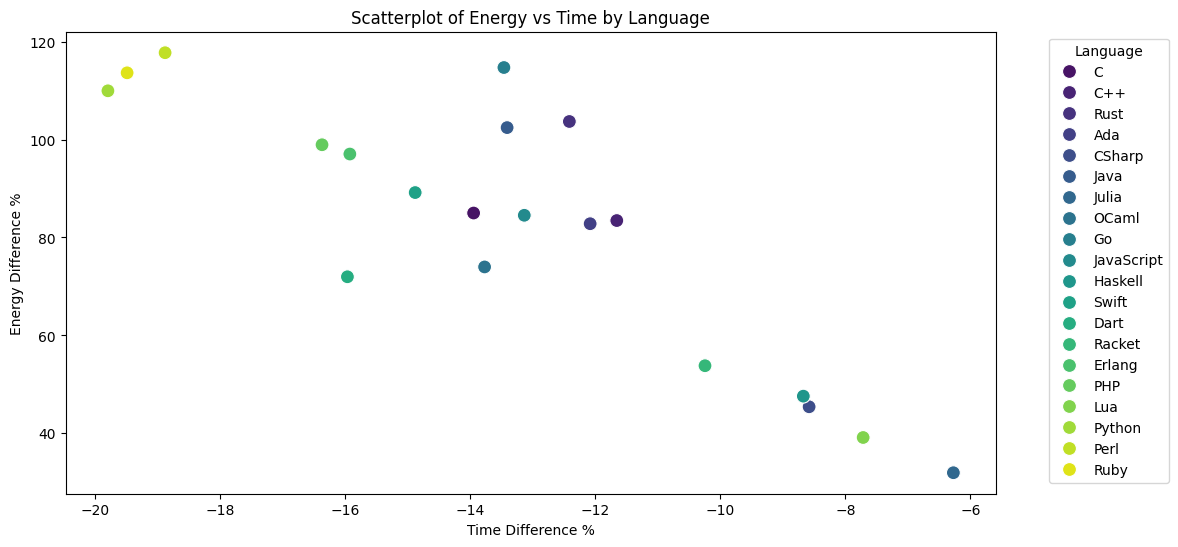

In [94]:
import seaborn as sns
# Criar o scatterplot
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(y='Time Difference %', x='Energy Difference %', hue='Language', data=result_df_normalized, s=100, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Time Difference %')
plt.ylabel('Energy Difference %')
plt.title('Scatterplot of Energy vs Time by Language')

# Adicionar legenda
scatter_plot.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_38019/1672285930.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Language', y='Energy Difference %', data=result_df_normalized, palette='viridis')


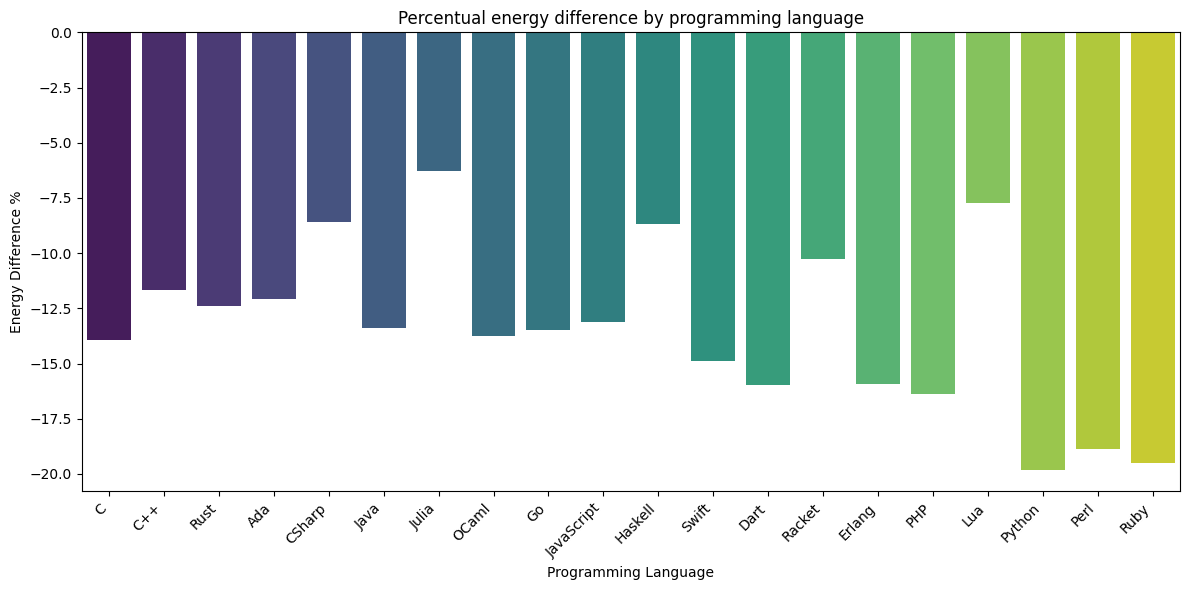

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o barplot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Language', y='Energy Difference %', data=result_df_normalized, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Programming Language')
plt.ylabel('Energy Difference %')
plt.title('Percentual energy difference by programming language')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()
#TODO

/tmp/ipykernel_38019/250615788.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Language', y='Time Difference %', data=result_df_normalized, palette='viridis')


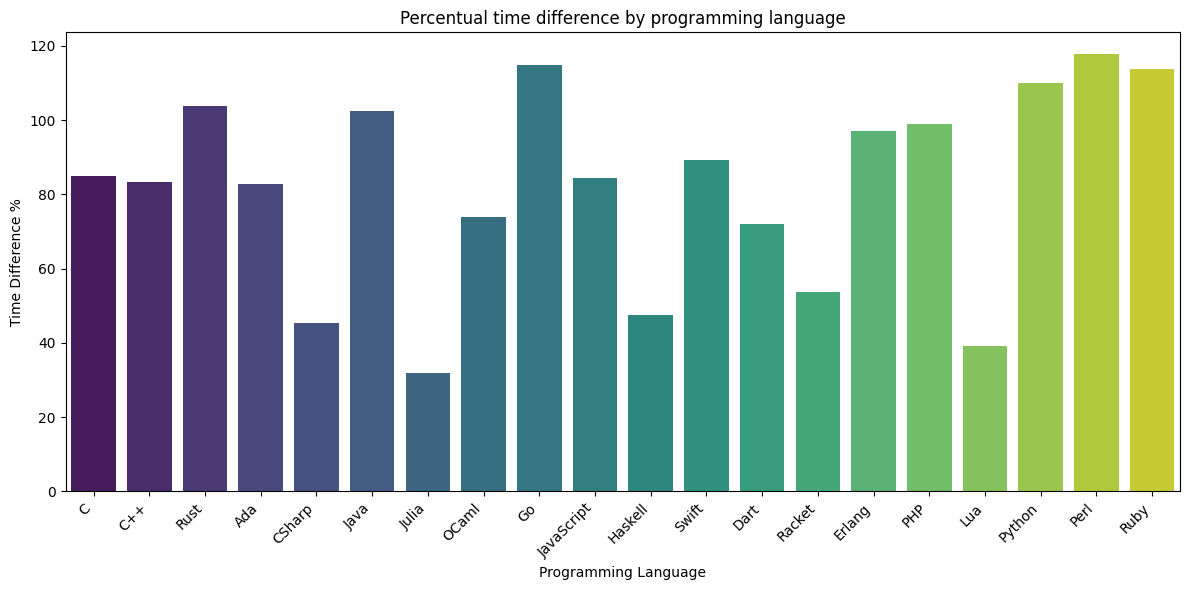

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o barplot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Language', y='Time Difference %', data=result_df_normalized, palette='viridis')

# Adicionar rótulos e título
plt.xlabel('Programming Language')
plt.ylabel('Time Difference %')
plt.title('Percentual time difference by programming language')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()
#TODO

# Recuperação de valores

In [33]:
dfTratamento = df.drop(['GPU', 'Core','DRAM'], axis=1)
dfTratamento['PowerLimit'].replace(-1, 999, inplace=True)
dfTratamento = dfTratamento.loc[dfTratamento['Package'] <= 0]
dfTratamento = dfTratamento.loc[dfTratamento['PowerLimit'] == 25]

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


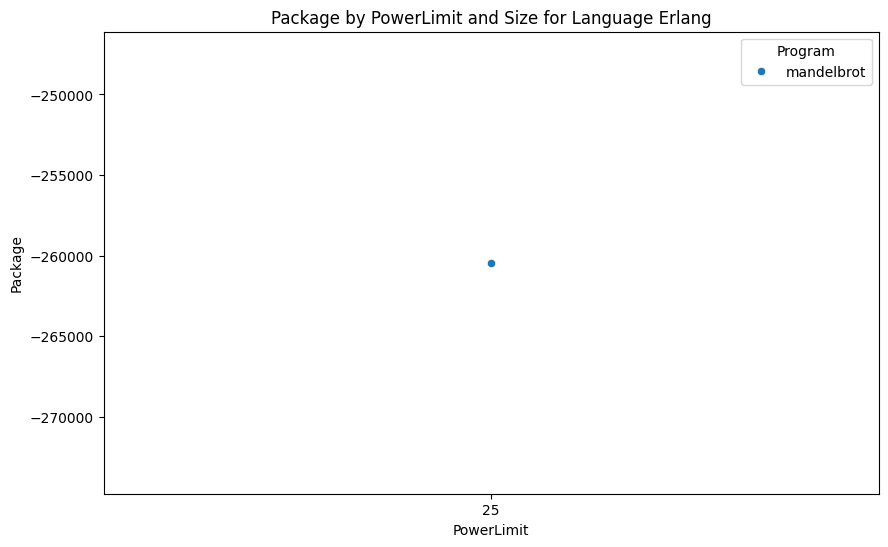

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

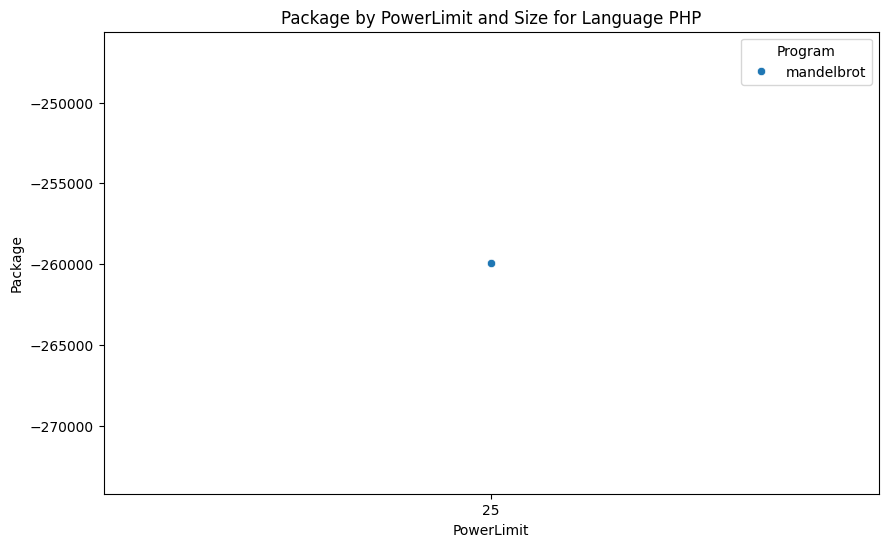

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


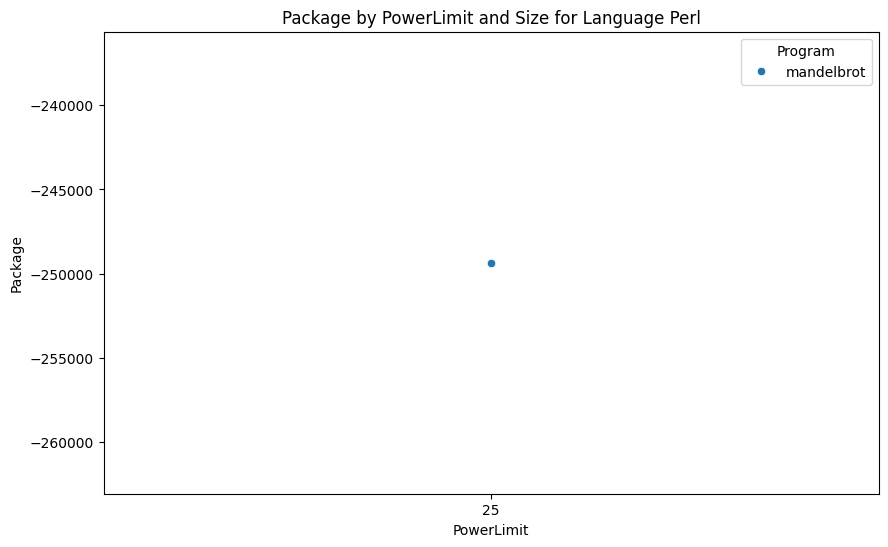

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

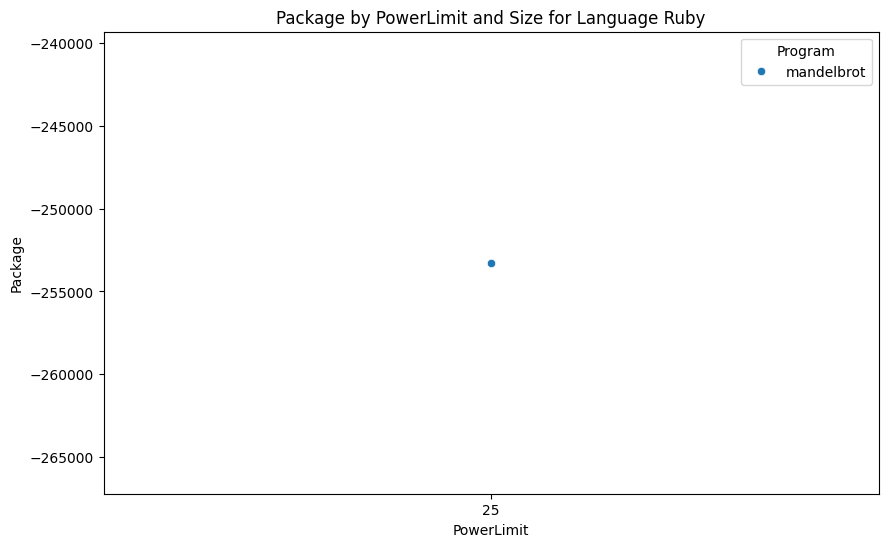

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

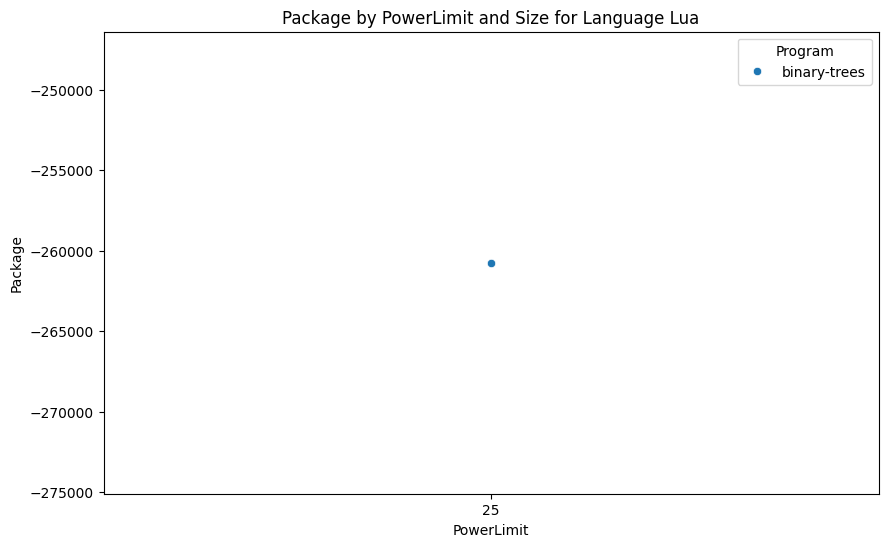

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

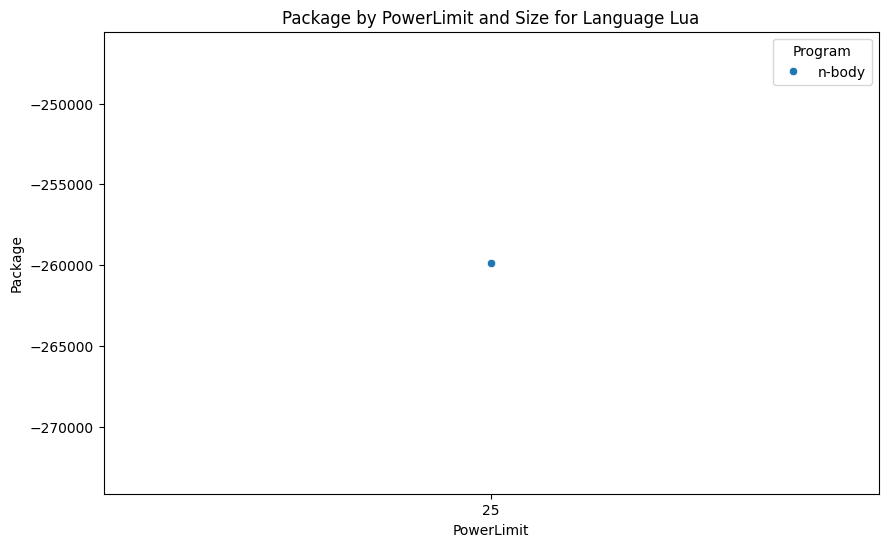

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

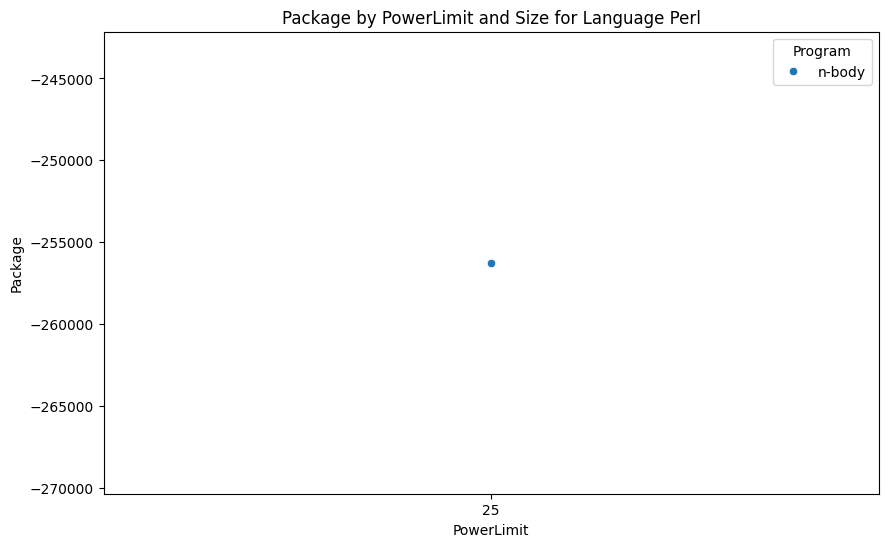

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


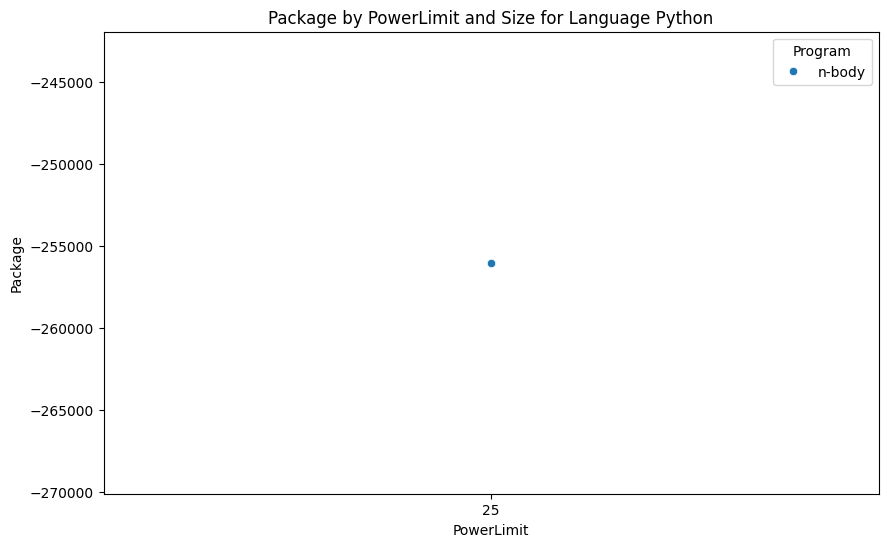

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

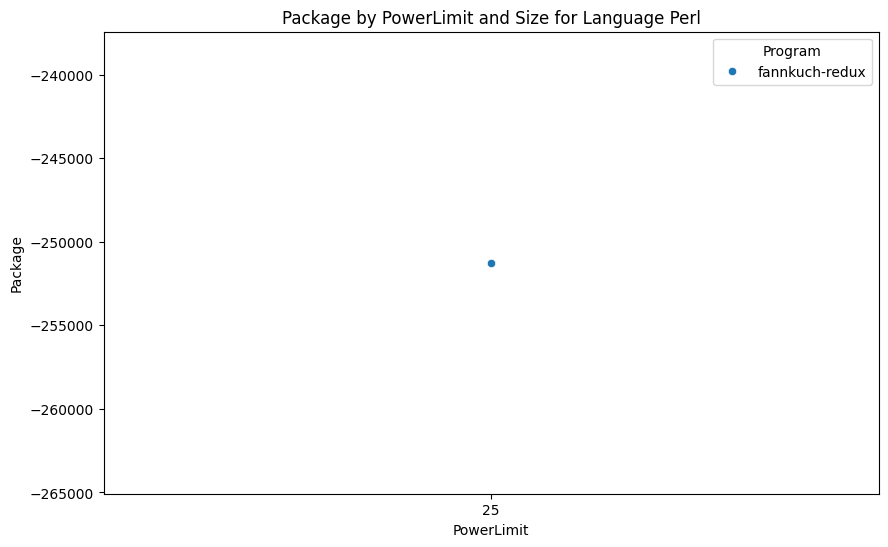

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


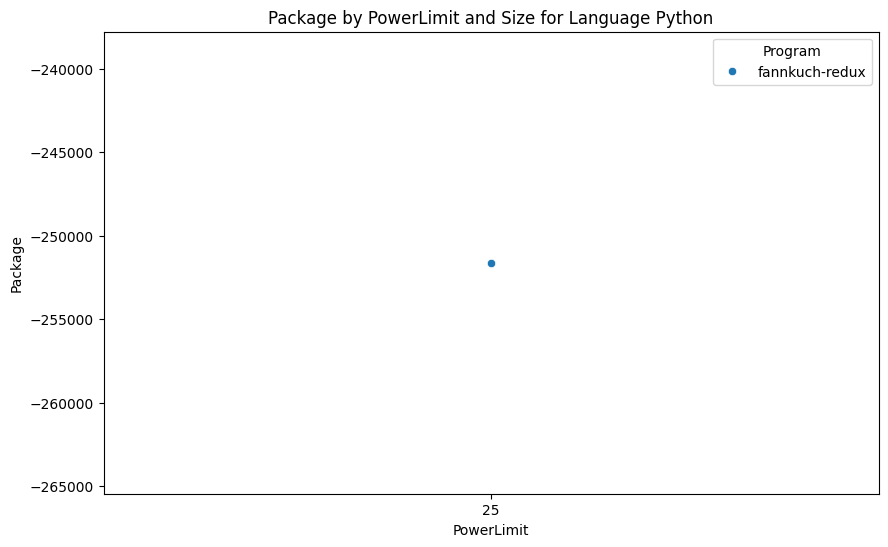

/tmp/ipykernel_80592/3639062366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)


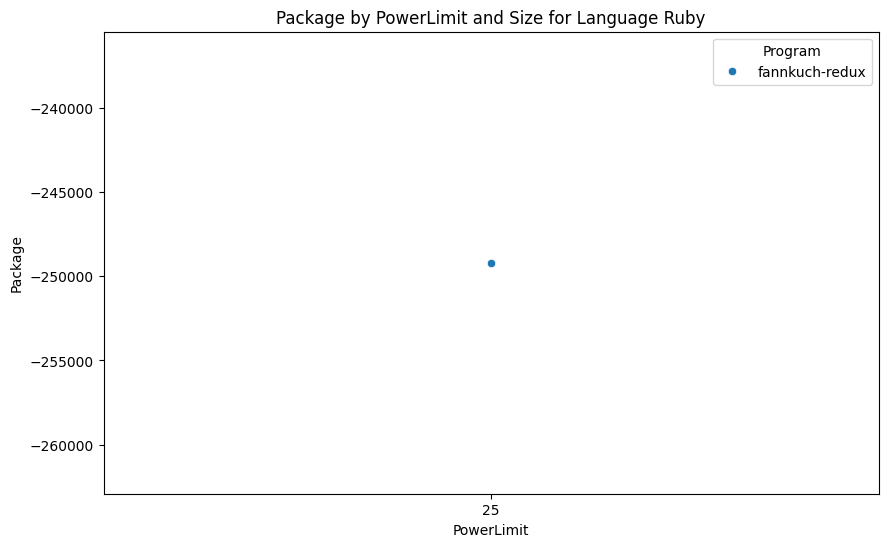

In [34]:
import matplotlib.pyplot as plt
import seaborn as sea

# Columns for comparison
#columns = ["Time", "Package", "Memory"]
columns = [ "Package"]
group_column = "PowerLimit"  # Specify the column to group by

# Iterate over the columns
for col in columns:
    programs = dfTratamento['Program'].unique()
    for program in programs:
        languages = dfTratamento['Language'].unique()
        for language in languages:
            plt.figure(figsize=(10, 6))
            
            data_subset = dfTratamento[(dfTratamento['Language'] == language) & (dfTratamento['Program'] == program)]
            if data_subset.shape[0]>0 :
                data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)

                ax = sea.scatterplot(data=data_subset, x=group_column, y=col, hue='Program')  # Add size='Size' parameter

                plt.xlabel(group_column)
                plt.ylabel(col)
                plt.title(f'{col} by {group_column} and Size for Language {language}')

                plt.legend(title='Program')
                plt.show()
